# COMP9418 Assignment 2

## *Tasks TODO*
- parameter initialization
- baseline (GMM model)
- mean negative log probability
- sample predictions.txt generator


In [74]:
import scipy.io as sio
from scipy.misc import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import hmmlearn
import sklearn
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [75]:
# make sure it's version 0.2.1 (install from github, not pip)
# pip install git+https://github.com/hmmlearn/hmmlearn.git
hmmlearn.__version__

'0.2.1'

In [76]:
sklearn.__version__

'0.19.0'

In [77]:
seed = 1234
rng = np.random.RandomState(seed)

In [78]:
# Load the data
trainData = sio.loadmat('./trajectories_train.mat')
testData = sio.loadmat('./trajectories_xtest.mat')

In [79]:
# Clean up the data
xtrain = trainData['xtrain'].reshape((-1, ))
ytrain = trainData['ytrain'].reshape((-1, ))
kf = StratifiedKFold(n_splits = 3, random_state=rng)
xtest = testData['xtest'].reshape((-1, ))
key = trainData['key']
key = [item[0] for item in key.reshape((-1, ))]

In [80]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
# print([sum(yval == i) for i in np.unique(ytrain)])

(1429L,)
(1429L,)
(1429L,)


# Data visualization

In [81]:
idx = 50

In [82]:
x = xtrain[idx]
y = ytrain[idx]

In [83]:
def plot_char(data, label):
    start_x = 0
    start_y = 0
    plt.plot(start_x, start_y, 'ro')
    for vel_h, vel_v, alpha in zip(data[0,], data[1, ], 1/(1 + np.exp(-data[2, ]/np.sum(data[2, ])))):
        start_x = start_x + vel_h
        start_y = start_y + vel_v
        plt.plot(start_x, start_y,'bo', alpha = alpha)
    plt.title('Character ' + key[label-1])
    plt.show()

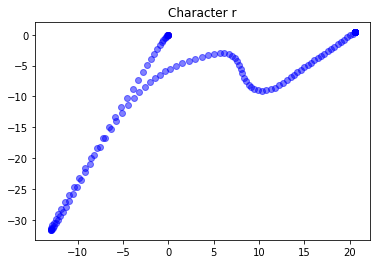

In [84]:
plot_char(x, y)

# Data Cleaning and Preparation

In [85]:
xtrain = np.asarray([seq.T for seq in xtrain])
xtest = np.asarray([seq.T for seq in xtest])

In [86]:
train_max = np.max(np.vstack(xtrain), axis=0)
train_min = np.min(np.vstack(xtrain), axis=0)
def rescale(seq):
    return (seq - train_min) / (train_max - train_min)

In [87]:
xtrain = np.asarray([rescale(seq) for seq in xtrain])
xtest = np.asarray([rescale(seq) for seq in xtest])

In [88]:
print(xtrain.shape)
print(xtest.shape)

(1429L,)
(1429L,)


In [89]:
lengths_train = list(map(lambda x: x.shape[0], xtrain))
lengths_test = list(map(lambda x: x.shape[0], xtest))

In [90]:
label_enc = LabelEncoder().fit(ytrain)
label_enc.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=uint8)

# Generative Classifier

In [91]:
def log_likelihood(hmm, sequence):

    logprob_frame = hmm._compute_log_likelihood(sequence)
    logprob_sequence, _ =  hmm._do_forward_pass(logprob_frame)

    return logprob_sequence

def log_likelihoods(hmm, sequences):

    ll = lambda seq: log_likelihood(hmm, seq)

    return np.fromiter(map(ll, sequences), dtype='float64')

def log_likelihoods_cond(cond_hmms, sequences):

    ll = lambda hmm: log_likelihoods(hmm, sequences)

    return np.vstack(map(ll, cond_hmms))

In [92]:
# Make sure to keep the init_params commented otherwise it doesn't work properly for some reason
class GenerativeClassifierHMM(BaseEstimator, ClassifierMixin):
    def __init__(self, hmm=GaussianHMM()):
        self.hmm = hmm
        self.class_cond_hmms_ = []

    def fit(self, sequences, labels, k):        
        class_counts = np.bincount(labels).astype(np.float)
        self.logprior = np.log(class_counts / np.sum(class_counts))
        
        for c in range(np.max(labels)+1):
            sequences_c = sequences[labels == c]
            X_c = np.vstack(sequences_c)
            lengths_c = list(map(len, sequences_c))
            class_cond_hmm = clone(self.hmm, safe=True)
            n_states_k = k[c]
            pi0 = np.eye(1, n_states_k)[0]
            trans0 = np.diag(np.ones(n_states_k)) + np.diag(np.ones(n_states_k-1), 1)
            trans0 /= trans0.sum(axis=1).reshape(-1, 1)
            class_cond_hmm.n_components = n_states_k
            class_cond_hmm.startprob_ = pi0
            class_cond_hmm.transmat_  = trans0
            class_cond_hmm.fit(X_c, lengths=lengths_c)
            self.class_cond_hmms_.append(class_cond_hmm)

        return self
    
    def predict(self, sequences):
        # 20 x N matrix
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)
    
    def predict_proba(self, sequences):
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)
        
        prob_post_norm = np.empty_like(log_post_unnorm)
        
        for i in range(log_post_unnorm.shape[1]):
            prob_post_norm[:,i] = log_post_unnorm[:,i] - logsumexp(log_post_unnorm[:,i].astype(np.float64))
            
        return prob_post_norm
    
    def generateSample(self, mClass, length):
        sel_hmm = self.class_cond_hmms_[mClass]
        x, _ = sel_hmm.sample(length)
        return x

# Guassian HMM (baseline)

In [93]:
# due to https://github.com/hmmlearn/hmmlearn/issues/158 and 
# https://github.com/hmmlearn/hmmlearn/issues/175
# the fitting process is going to give a LOT of warnings
# so we hide them in this notebook
import warnings
warnings.filterwarnings('ignore')

In [94]:
hmm = GaussianHMM(n_components=25, n_iter=10, random_state=seed)
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.tile(10, 20))

KeyboardInterrupt: 

In [ ]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))

In [ ]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

In [ ]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[train_index]))

In [ ]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

In [ ]:
probs = hmm_classifier.predict_proba(xtest)
print(probs)

In [48]:
print(key[np.argmax(probs[:,0])])

r


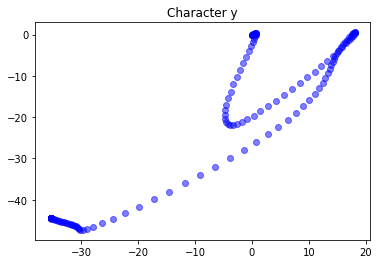

In [97]:
index = 53
x = xtest[index] * (train_max - train_min) + train_min
plot_char(x.T, np.argmax(probs[:,index])+1)

In [36]:
idx = 2
print(np.round(probs[:,idx], 4))
print(key[np.argmax(probs[:,idx]) + 1])
print(key[ytrain[train_index][idx]])

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
g
g


In [37]:
import pandas
conf_mat = pandas.DataFrame(confusion_matrix(ytrain[test_index], y_val_pred))
conf_mat.columns = key
conf_mat.index = key
conf_mat

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
a,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,26,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
c,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,10,0,1,4,0,0,0,0,0,0,0,4,0,0
l,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,2,0,0
m,0,0,0,0,0,0,0,0,18,3,0,0,0,0,0,0,0,2,0,0
n,0,0,0,0,0,0,0,0,4,16,0,0,0,0,0,0,0,1,0,0


In [38]:
import pandas
conf_mat = pandas.DataFrame(confusion_matrix(ytrain[train_index], y_train_pred))
conf_mat.columns = key
conf_mat.index = key
conf_mat

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
a,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,55,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
c,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,24,0,1,7,0,0,0,0,0,0,0,6,0,0
l,0,0,0,0,0,0,3,48,0,0,0,0,0,0,0,0,0,1,0,0
m,0,0,0,0,0,0,2,0,37,2,0,0,0,0,0,0,0,3,0,0
n,0,0,0,0,0,0,0,0,3,35,0,0,0,0,0,0,0,3,0,0


### Observations of validations confusion matrix
* h gets mixed up with n, w
* m gets mixed up with m, u, w
* n gets mixed up with m, w
* u gets mixed up with w

### Observations of training confusion matrix
* h gets mixed up with n, w
* m gets mixed up with u, w
* n gets mixed up with n, w, m
* p gets mixed up with n
* u gets mixed up with a, w
* w gets mixed up with a, n

Generate a random sample from the gmm for a certain class

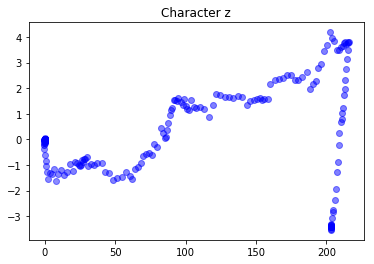

In [39]:
myClass = [20]
x = hmm_classifier.generateSample(label_enc.transform(myClass)[0], 200)
x = x * (train_max - train_min) + train_min
plot_char(x.T, myClass[0])

### Basic Cross Validation

In [526]:
cv1_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k, 
#                       init_params='mc',
                      n_iter=10,
                      random_state=seed)
    correct = 0.0
    for train_index, test_index in kf.split(xtrain, ytrain):
#         hmm.startprob_ = pi0
#         hmm.transmat_  = trans0
        hmm_classifier = GenerativeClassifierHMM(hmm)

        hmm_classifier.fit(xtrain[train_index], label_enc.transform(ytrain[train_index]), np.tile(k, 20))
        y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))
        correct += np.sum(y_val_pred == ytrain[test_index])
    accuracy = correct/xtrain.shape[0]
    cv1_results[k] = accuracy
    print('Accuracy', k, accuracy)

('Accuracy', 5, 0.7998600419874038)
('Accuracy', 6, 0.8621413575927221)
('Accuracy', 7, 0.8530440867739678)
('Accuracy', 8, 0.8761371588523443)
('Accuracy', 9, 0.8803358992302309)
('Accuracy', 10, 0.8999300209937019)
('Accuracy', 11, 0.900629811056683)
('Accuracy', 12, 0.9062281315605318)
('Accuracy', 13, 0.9097270818754374)
('Accuracy', 14, 0.9111266620013996)
('Accuracy', 15, 0.9188243526941917)
('Accuracy', 16, 0.9118264520643807)
('Accuracy', 17, 0.9132260321903429)
('Accuracy', 18, 0.9111266620013996)
('Accuracy', 19, 0.9104268719384184)
('Accuracy', 20, 0.9146256123163051)
('Accuracy', 21, 0.9125262421273618)
('Accuracy', 22, 0.9181245626312107)
('Accuracy', 23, 0.9230230930720784)
('Accuracy', 24, 0.9258222533240028)
('Accuracy', 25, 0.9258222533240028)
('Accuracy', 26, 0.9153254023792862)
('Accuracy', 27, 0.9230230930720784)
('Accuracy', 28, 0.9286214135759272)
('Accuracy', 29, 0.9209237228831351)
('Accuracy', 30, 0.9258222533240028)


In [ ]:
cv2_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k,
                      n_iter=10,
                      random_state=seed)
    class_cond_accuracies = {}
    for train_index, test_index in kf.split(xtrain, ytrain):
        hmm_classifier = GenerativeClassifierHMM(hmm)

        hmm_classifier.fit(xtrain[train_index], label_enc.transform(ytrain[train_index]), np.tile(k, 20))
        for label in label_enc.classes_:
            class_cond_xtest = xtrain[test_index][ytrain[test_index] == label]
            y_class_cond_pred = label_enc.inverse_transform(hmm_classifier.predict(class_cond_xtest))
            class_cond_accuracy = (y_class_cond_pred == label).mean()
            if (not class_cond_accuracies.has_key(label)):
                class_cond_accuracies[label] = []
            class_cond_accuracies[label] = class_cond_accuracies[label] + [class_cond_accuracy]

    k_states_results = {}
    for label in label_enc.classes_:
        k_states_results[label] = np.mean(class_cond_accuracies[label])
    cv2_results[k] = k_states_results
    print('Average for k = ', k, np.mean(cv2_results[k].values()))

In [465]:
result = pandas.DataFrame(cv2_results).T
result.columns = key
result.round(4)

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
5,0.9519,0.9524,0.9091,0.2240,0.9896,0.9733,0.1930,0.7977,0.5507,0.4349,0.9848,0.8720,0.8246,0.7044,1.0000,0.4848,0.9889,0.7254,1.0000,1.0
6,0.9638,0.9167,0.9545,1.0000,0.9896,1.0000,0.4386,0.8234,0.7161,0.4849,0.9545,0.9281,0.8947,0.7404,1.0000,0.4394,0.9889,0.6719,0.9855,1.0
7,0.9757,0.9048,0.9848,0.9855,0.9896,1.0000,0.3158,0.7972,0.5527,0.4683,0.9697,0.9281,0.9474,0.7746,0.9848,0.2973,0.9889,0.8614,0.9855,1.0
8,0.9877,0.9524,0.9848,1.0000,0.9896,1.0000,0.2281,0.8613,0.5672,0.5167,0.9697,0.9275,0.9649,0.8096,1.0000,0.5635,1.0000,0.8789,0.9855,1.0
9,0.9757,0.9643,1.0000,1.0000,0.9896,1.0000,0.2456,0.8979,0.6555,0.5016,0.9848,0.9143,0.9298,0.8263,0.9848,0.5332,1.0000,0.8956,0.9710,1.0
10,0.9877,0.9643,1.0000,1.0000,0.9896,1.0000,0.4561,0.9103,0.6403,0.5643,0.9848,0.9710,0.9474,0.8605,1.0000,0.6263,1.0000,0.8439,0.9710,1.0
11,0.9877,0.9524,1.0000,1.0000,0.9896,1.0000,0.4737,0.8599,0.6416,0.5635,0.9848,0.9432,0.9649,0.9307,0.9690,0.6732,1.0000,0.8623,0.9710,1.0
12,1.0000,0.9405,1.0000,1.0000,0.9896,1.0000,0.4912,0.8727,0.6713,0.5976,0.9848,0.9432,0.9474,0.8965,0.9848,0.6861,1.0000,0.8789,1.0000,1.0
13,0.9877,0.9524,1.0000,1.0000,0.9896,1.0000,0.3860,0.8865,0.6713,0.6786,0.9848,0.9432,0.9474,0.9307,1.0000,0.7338,1.0000,0.8614,1.0000,1.0
14,0.9877,0.9405,1.0000,1.0000,0.9896,1.0000,0.4386,0.8481,0.6858,0.6452,1.0000,0.9287,0.9474,0.9298,0.9683,0.7965,1.0000,0.8965,1.0000,1.0


In [507]:
# Highest n_states for each character
np.asarray(range(5, 31))[np.argmax(np.asarray(result), axis=0)]

array([12, 22,  9,  6,  5,  6, 28, 28,  6, 24, 14, 19, 28, 28,  5, 27,  8,
       26,  5,  5])

In [509]:
# Tested states
# [28, 28, 28, 28, 28, 28, 28, 28, 30, 20, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.939xx
# [28, 28, 28, 28, 28, 28, 28, 28, 25, 20, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.93983402489626555
# [28, 28, 28, 28, 28, 28, 28, 28, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.94190871369294604
# [28, 28, 28, 28, 28, 28, 28, 28, 25, 25, 28, 28, 28, 28, 28, 15, 28, 26, 28, 28] 0.91701244813278004
# [28, 28, 28, 28, 28, 28, 28, 10, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.91xx
# [28, 28, 28, 28, 28, 28, 28, 21, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.94190871369294604
# [28, 28, 28, 28, 28, 28, 15, 28, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28] 0.92323651452282163

# Winner
# [28, 28, 28, 28, 28, 28, 28, 28, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28]

## Retraining the classifier using the "Optimized" number of states

In [40]:
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.array([28, 28, 28, 28, 28, 28, 28, 28, 25, 25, 28, 28, 28, 28, 28, 27, 28, 26, 28, 28])) 

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=25, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [41]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))

In [42]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Validation Accuracy', 0.94190871369294604)


In [43]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[train_index]))

In [44]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

('Training Accuracy', 0.96620908130939809)


# Gaussian Mixture HMM (meh)


In [29]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    filtered = np.empty_like(data)
    
    for i in range(filtered.shape[0]):
        ll = np.zeros(data[i].shape)
        
        for j in range(3):
            ll[:,j] = lfilter(b, a, data[i][:,j])
        
        filtered[i] = ll
    return filtered

# Filter requirements.
order = 4
fs = 200.0       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

xtrain_filtered = butter_lowpass_filter(xtrain, cutoff, fs, order)


In [30]:
# Parameters
n_states = 10

# initial guess for EM
# pi0 = np.eye(1, n_states)[0] # start probability
# pi0

# initial guess for EM
# transition matrix
# trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
# trans0 /= trans0.sum(axis=1).reshape(-1, 1)
# trans0

In [31]:
hmm = GaussianHMM(n_components=n_states, 
#                   init_params='mc',
                  n_iter=10,
                  random_state=seed)
# hmm.startprob_ = pi0
# hmm.transmat_  = trans0

In [32]:
# due to https://github.com/hmmlearn/hmmlearn/issues/158 and 
# https://github.com/hmmlearn/hmmlearn/issues/175
# the fitting process is going to give a LOT of warnings
# so we hide them in this notebook
import warnings
warnings.filterwarnings('ignore')

In [71]:
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain_filtered[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.tile(15, 20))

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=10, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [72]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[test_index]))

In [73]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Validation Accuracy', 0.96887966804979253)


In [74]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[train_index]))

In [75]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

('Training Accuracy', 0.96409714889123543)


## Cross validation on number of states, cutoff frequency

In [33]:
# Parameter initialization
order = 4
fs = 200.0  

hmm = GaussianHMM(n_components=n_states,
                  n_iter=10,
                  random_state=seed)

In [ ]:
cv3_results = {}
for k in range(10, 31):
    for cutoff in [2, 3, 4, 5, 6, 7, 8, 9, 10]:  # desired cutoff frequency of the filter, Hz
        xtrain_filtered = butter_lowpass_filter(xtrain, cutoff, fs, order)
        val_acc = 0.0
        tra_acc = 0.0
        for train_index, test_index in kf.split(xtrain, ytrain):
            hmm_classifier = GenerativeClassifierHMM(hmm)

            hmm_classifier.fit(xtrain_filtered[train_index], 
                       label_enc.transform(ytrain[train_index]),
                       np.tile(k, 20))

            y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[test_index]))
            val_acc += (y_val_pred == ytrain[test_index]).mean()
            
            y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[train_index]))
            
            tra_acc += (y_train_pred == ytrain[train_index]).mean()
            
        val_acc /= kf.get_n_splits()
        print('Validation Accuracy: k = ' + str(k) + '; cut_freq = ' + str(cutoff) + ' ---> ' + str(val_acc))
        
        cv3_results[(k, cutoff)] = val_acc

Validation Accuracy: k = 10; cut_freq = 2 ---> 0.941175230565
Validation Accuracy: k = 10; cut_freq = 3 ---> 0.974032995778
Validation Accuracy: k = 10; cut_freq = 4 ---> 0.951644298248
Validation Accuracy: k = 10; cut_freq = 5 ---> 0.951651732219
Validation Accuracy: k = 10; cut_freq = 6 ---> 0.943244786528
Validation Accuracy: k = 10; cut_freq = 7 ---> 0.929225864831
Validation Accuracy: k = 10; cut_freq = 8 ---> 0.915280264919
Validation Accuracy: k = 10; cut_freq = 9 ---> 0.906148170785
Validation Accuracy: k = 10; cut_freq = 10 ---> 0.906148170785
Validation Accuracy: k = 11; cut_freq = 2 ---> 0.947467751185
Validation Accuracy: k = 11; cut_freq = 3 ---> 0.965722956995
Validation Accuracy: k = 11; cut_freq = 4 ---> 0.956534975435
Validation Accuracy: k = 11; cut_freq = 5 ---> 0.954533608424
Validation Accuracy: k = 11; cut_freq = 6 ---> 0.947453901172
Validation Accuracy: k = 11; cut_freq = 7 ---> 0.934897577887
Validation Accuracy: k = 11; cut_freq = 8 ---> 0.925800352473
Validat

# Gaussian Mixture HMM

**Note**:
I was getting some results (70%) with these parameters when I was on version 0.2.0 but after updating to the latest
version (0.2.1), GMMHMM hasn't been great and it's taking too long to run. There are some open issues on their Github which seem to suggest GMMHMM is a bit buggy atm.

In [97]:
# Parameters
n_states = 3
n_mix = 10
# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0.5],
       [ 0. ,  0. ,  1. ]])

In [102]:
gmmhmm = GMMHMM(n_components=n_states, 
                n_mix=n_mix,
                covariance_type='diag',
                init_params='mc',
                n_iter=3,
                random_state=rng)
gmmhmm.startprob_ = pi0
gmmhmm.transmat_  = trans0

In [103]:
hmm_classifier = GenerativeClassifierHMM(gmmhmm)
hmm_classifier.fit(xtrain, label_enc.transform(ytrain))

GenerativeClassifierHMM(hmm=GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=None,
    covars_weight=None, init_params='mc', means_prior=0.0,
    means_weight=0.0, min_covar=0.001, n_components=3, n_iter=3, n_mix=10,
    params='stmcw',
    random_state=<mtrand.RandomState object at 0x000000000A48A3A8>,
    startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False,
    weights_prior=1.0))

In [104]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))

(20L, 429L)
(20L,)


In [105]:
print('Accuracy', (y_val_pred == yval).mean())

('Accuracy', 0.38694638694638694)


# Guassian Mixture Classifier (Zero Padded Data)

#### Padding sequances with zero so they all have the same length

In [45]:
max_length = 250

In [46]:
def pad_seq(seq):
    seq_len = seq.shape[0]
    x = np.pad(seq[:, 0], (0, max_length - seq_len%max_length), 'constant')
    y = np.pad(seq[:, 1], (0, max_length - seq_len%max_length), 'constant')
    z = np.pad(seq[:, 2], (0, max_length - seq_len%max_length), 'constant')
    return np.stack((x, y, z)).T

In [47]:
xtrain_zp = np.asarray([pad_seq(seq) for seq in xtrain])
xtest_zp = np.asarray([pad_seq(seq) for seq in xtest])

In [48]:
print(xtrain_zp.shape)
print(xtest_zp.shape)

(1429, 250, 3)
(1429, 250, 3)


In [49]:
class GaussianMixtureClassifier():
    '''
    GaussianMixtureClassifier is classifier where a seperate GMM is trained on
    different classes and it has a similar API to ski-learn classifiers
    Parameters
    '''
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        K = int(np.max(y)+1)
        self.models = []
        for k in range(K):
            model = GaussianMixture(**self.kwargs)
            model.fit(X[y==k])
            self.models.append(model)
        return self

    def predict(self, X):
        loglikelihood = [ model.score_samples(X) for model in self.models ]
        return np.vstack(loglikelihood).argmax(axis=0)
    
    def score(self, X):
        return self.predict(X)

    def score_samples(self, X):
        loglikelihood = [ model.score_samples(X) for model in self.models ]
        return np.vstack(loglikelihood).T

In [50]:
# Reshaping the data into a two dimensional array

In [51]:
xtrain_zp = xtrain_zp.reshape(xtrain_zp.shape[0], xtrain_zp.shape[1]* xtrain_zp.shape[2])
ytrain_zp = ytrain - 1

In [52]:
print(xtrain_zp.shape)
print(set(ytrain_zp))

(1429, 750)
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


In [53]:
# Diagonal Covariance

In [54]:
for train_index, test_index in kf.split(xtrain, ytrain):
    gmm_classifier = GaussianMixtureClassifier(n_components=10, covariance_type='diag', verbose=False, max_iter=1000)

    gmm_classifier.fit(xtrain_zp[train_index], ytrain[train_index]-1)
    accuracy = (gmm_classifier.predict(xtrain_zp[test_index]) == (ytrain[test_index] - 1)).mean()
    print('Accuracy: ', accuracy)

('Accuracy: ', 0.96680497925311204)
('Accuracy: ', 0.97268907563025209)
('Accuracy: ', 0.97027600849256901)


In [55]:
# Full Covariance

In [56]:
for train_index, test_index in kf.split(xtrain, ytrain):
    gmm_classifier = GaussianMixtureClassifier(n_components=10, covariance_type='full', verbose=False, max_iter=1000)
    gmm_classifier.fit(xtrain_zp[train_index], ytrain[train_index]-1)
    accuracy = (gmm_classifier.predict(xtrain_zp[test_index]) == (ytrain[test_index] - 1)).mean()
    print('Accuracy: ', accuracy)

('Accuracy: ', 1.0)
('Accuracy: ', 0.99159663865546221)
('Accuracy: ', 0.99150743099787686)


# Low-pass Filtering of data

In [24]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    filtered = np.empty_like(data)
    
    for i in range(filtered.shape[0]):
        ll = np.zeros(data[i].shape)
        
        for j in range(3):
            ll[:,j] = lfilter(b, a, data[i][:,j])
        
        filtered[i] = ll
    return filtered

# Filter requirements.
order = 4
fs = 200.0       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

xtrain_filtered = butter_lowpass_filter(xtrain, cutoff, fs, order)

In [25]:
hmm = GaussianHMM(n_iter=10, random_state=seed)
hmm_classifier = GenerativeClassifierHMM(hmm)

hmm_classifier.fit(xtrain_filtered[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.tile(15, 20))

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=1, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [26]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[test_index]))

In [27]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Validation Accuracy', 0.96887966804979253)


In [28]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[train_index]))

In [29]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

('Training Accuracy', 0.96409714889123543)


## Cross validation on number of states, cutoff frequency

In [31]:
# Parameter initialization
order = 4
fs = 200.0  

hmm = GaussianHMM(n_iter=10, random_state=seed)

In [ ]:
cv3_results = {}
for k in range(10, 31):
    for cutoff in [2, 3, 4, 5, 6, 7, 8, 9, 10]:  # desired cutoff frequency of the filter, Hz
        xtrain_filtered = butter_lowpass_filter(xtrain, cutoff, fs, order)
        val_acc = 0.0
        tra_acc = 0.0
        for train_index, test_index in kf.split(xtrain, ytrain):
            hmm_classifier = GenerativeClassifierHMM(hmm)

            hmm_classifier.fit(xtrain_filtered[train_index], 
                       label_enc.transform(ytrain[train_index]),
                       np.tile(k, 20))

            y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[test_index]))
            val_acc += (y_val_pred == ytrain[test_index]).mean()
            
            y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain_filtered[train_index]))
            
            tra_acc += (y_train_pred == ytrain[train_index]).mean()
            
        val_acc /= kf.get_n_splits()
        print('Validation Accuracy: k = ' + str(k) + '; cut_freq = ' + str(cutoff) + ' ---> ' + str(val_acc))
        
        cv3_results[(k, cutoff)] = val_acc

Validation Accuracy: k = 10; cut_freq = 2 ---> 0.941175230565
Validation Accuracy: k = 10; cut_freq = 3 ---> 0.974032995778


# Appendix Material
* scaling and guassian filter (although guassian filter didn't work) https://www.researchgate.net/publication/4090432_Principal_Component_Analysis_for_Online_Handwritten_Character_Recognition